# Install Requirements

In [133]:
# !sudo yum install ghostscript -y
# !sudo yum update -y
# !sudo yum install ImageMagick-devel -y
# !pip install pdfplumber
# !pip install celluloid
# !conda install -c conda-forge ffmpeg -y

# Imports

In [134]:
import pandas as pd
import pdfplumber
pdfplumber.__version__
import random
import matplotlib.pyplot as plt
import time
import celluloid
from celluloid import Camera # getting the camera
from IPython.display import HTML
import numpy as np

%matplotlib inline

In [197]:
SOP = "MCD-088122"
sop_file_path = f"data/sop/Kalamazoo/{SOP}.pdf"

In [198]:
pdf = pdfplumber.open(sop_file_path)

In [199]:
len(pdf.pages)

24

In [258]:
sample_page = pdf.pages[1]

## Draw All Bounding Boxes

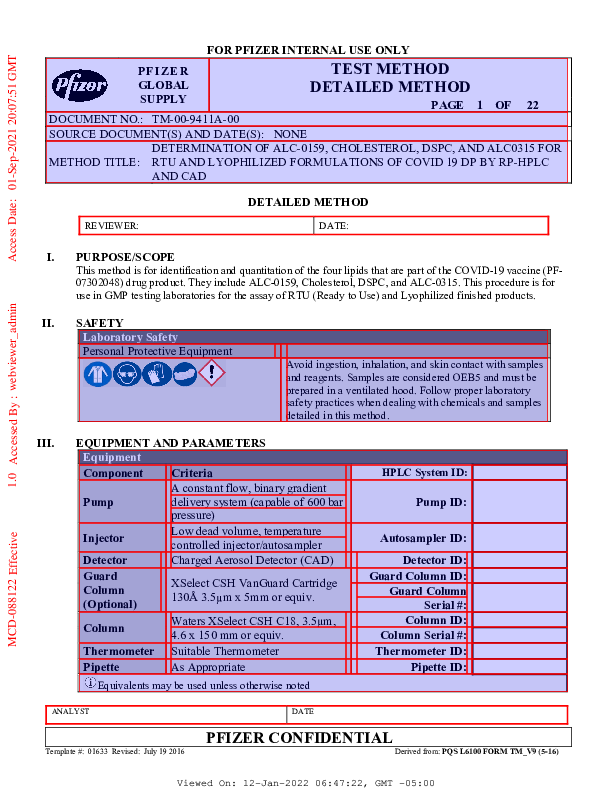

In [288]:
img = sample_page.to_image()
img.draw_rects(tf.cells)

## Draw Table Bounding Boxes only

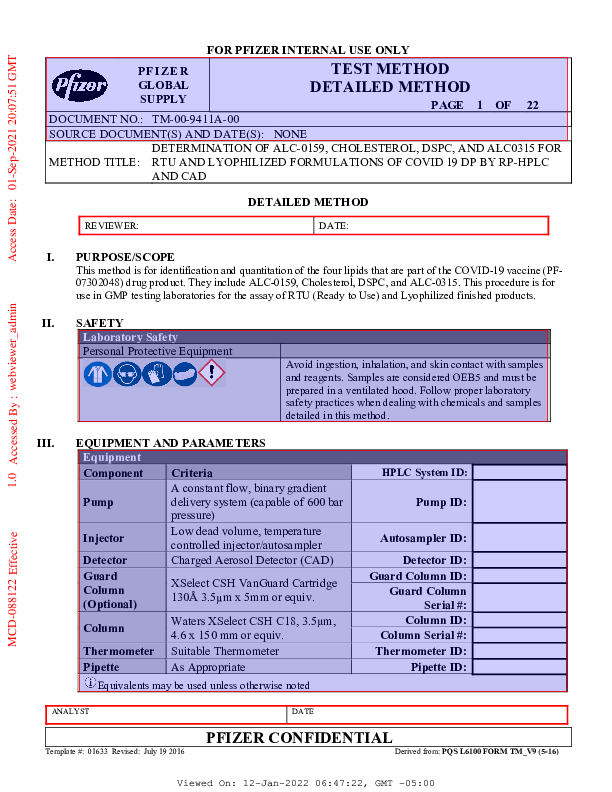

In [286]:
img = sample_page.to_image()
img.draw_rects([item.bbox for item in tf.tables])

# Show Cells One By One as an Animation

In [275]:
def animate_cells(page, tablefinder, sleep=0.3, refresh=True):
    _img = page.to_image()
    fig, ax = plt.subplots(figsize=(20,15))
    camera = Camera(fig)
    for cell in tablefinder.cells:
        if refresh:
            _img = page.to_image()
        _img.draw_rect(cell, fill=(random.randint(1, 255), random.randint(1, 255), random.randint(1, 255), 50))
        ax.imshow(_img.annotated);
        time.sleep(sleep)
        camera.snap()
    animation = camera.animate()
    animation_html = HTML(animation.to_html5_video())
    
    return animation_html

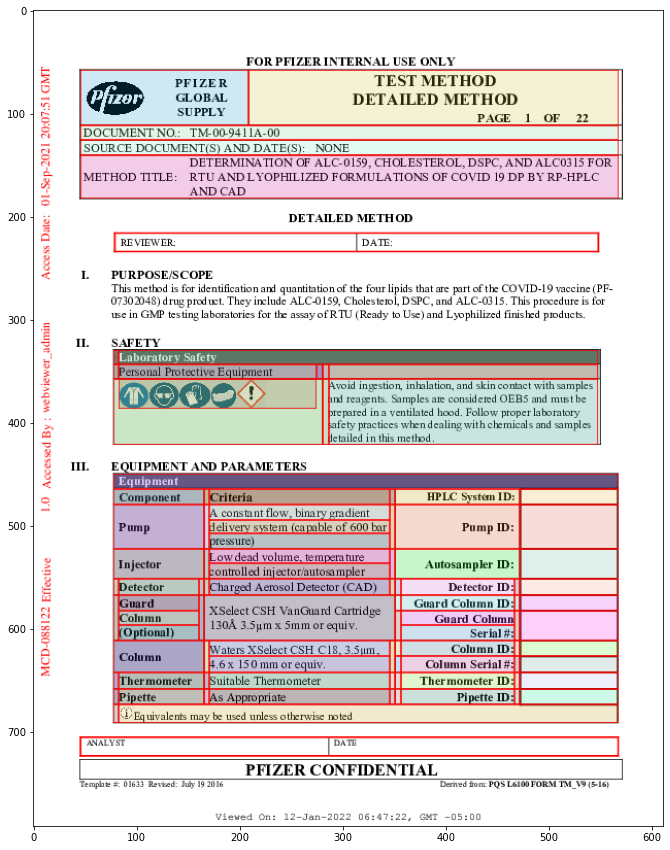

In [276]:
animation_1 = animate_cells(sample_page, tf, refresh=False)

In [277]:
animation_1

# Show Cells Separately one by one as an Animation

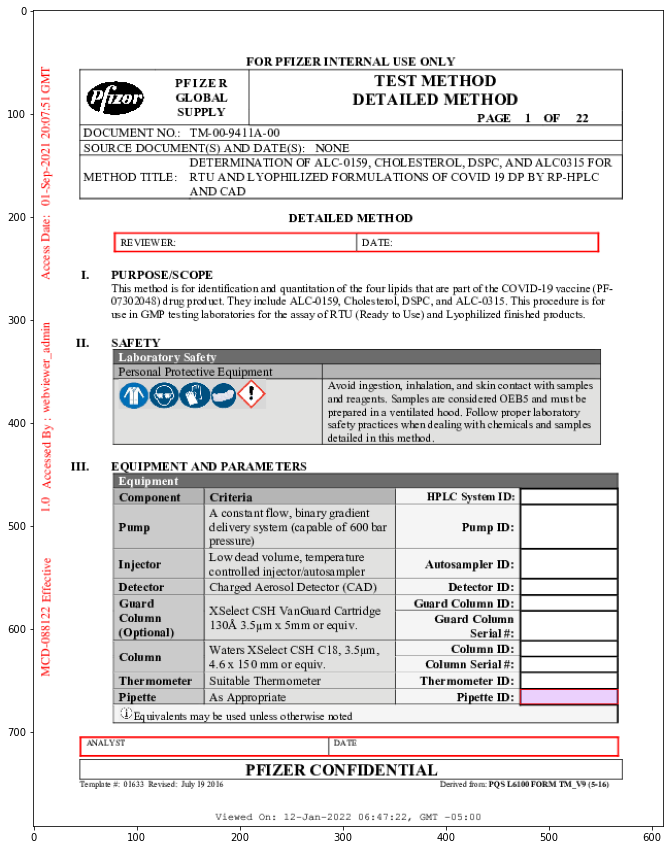

In [278]:
animation_2 = animate_cells(sample_page, tf, refresh=True)

In [279]:
animation_2

# Draw Edges using Animation

In [225]:
def animate_edges(page, tablefinder, sleep=0.3, refresh=True):
    _img = page.to_image()
    fig, ax = plt.subplots(figsize=(20,15))
    camera = Camera(fig)
    for edge in tablefinder.edges:
        if refresh:
            _img = page.to_image()
#         _img.draw_lines(edge, fill=(random.randint(1, 255), random.randint(1, 255), random.randint(1, 255), 50))
        _img.draw_line(edge)
        ax.imshow(_img.annotated);
        time.sleep(sleep)
        camera.snap()
    animation = camera.animate()
    animation_html = HTML(animation.to_html5_video())
    
    return animation_html

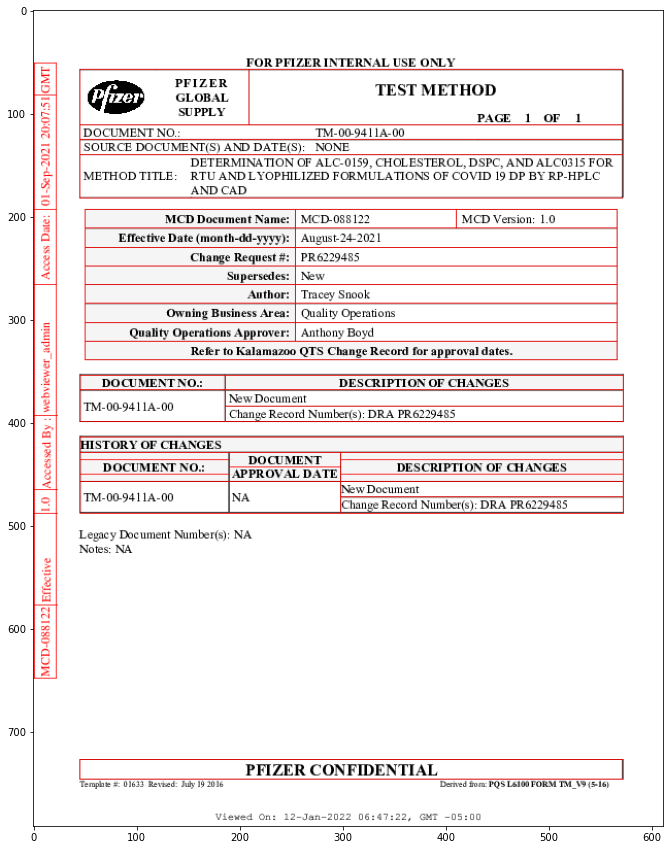

In [228]:
edge_anim_1 = animate_edges(sample_page, tf, refresh=False)

In [229]:
edge_anim_1

# Filter Out Cells
- **Problem**: We are having extra cells inside real table cells. The cause of that can be the original document layout that was converted to PDF.
- **Solution**: We need to iterate on each cell in a table and remove the ones that are inside another cell.
    - **Time Complexity**: If given table is M*N then at most 2*M*N cells can be present and half of them will be needed to remove. The naive solution will consider all pairs of them which will run in O((M*N)^2) time. The expected values of M, N:   **0 < M, N < 20**
    - **Space Complexity**: O(2*M*N) = O(M*N). Any auxiliary storage will be less that that so asymptotic value is still relative to table size.

In [25]:
img = sample_page.to_image()

In [28]:
edges_df = pd.DataFrame(tf.edges)

In [34]:
cells_df = pd.DataFrame([{'x1':item[0], 'y1':item[1], 'x2':item[2], 'x3':item[3]} for item in tf.cells])

In [42]:
inters_df = pd.DataFrame(tf.intersections.values())

## Edges

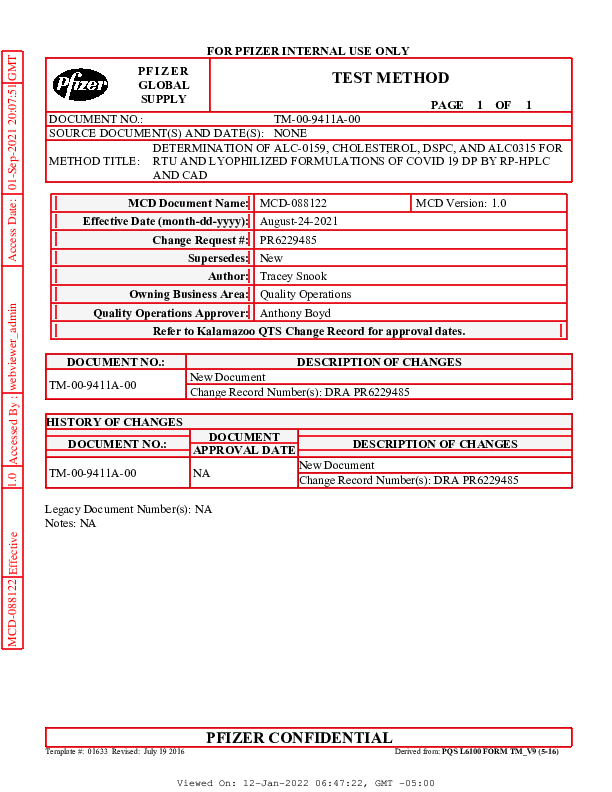

In [49]:
img = sample_page.to_image()
img.draw_rects(tf.edges)

In [32]:
edges_df.describe()

,x0,y0,x1,y1,width,height,linewidth,page_number,top,bottom,doctop
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0,73.0,73.000000,73.000000,73.000000
mean,135.572580,440.688034,324.523150,476.130116,188.950570,35.442082,0.0,1.0,315.869884,351.311966,315.869884
std,162.766168,164.505115,238.763098,167.917030,238.217045,101.543179,0.0,0.0,167.917030,164.505115,167.917030
min,1.120000,45.480000,1.577500,45.480000,0.000000,0.000000,0.0,1.0,51.024000,51.024000,51.024000
25%,45.667500,341.760000,56.280000,362.800000,0.000000,0.000000,0.0,1.0,195.960000,230.190000,195.960000
50%,51.000000,454.560000,254.480000,488.775000,20.910000,0.000000,0.0,1.0,303.225000,337.440000,303.225000
75%,249.000000,561.810000,571.320000,596.040000,515.400000,13.800000,0.0,1.0,429.200000,450.240000,429.200000
max,572.152500,740.976000,572.280000,740.976000,526.200000,597.636000,0.0,1.0,746.520000,746.520000,746.520000


## Cells

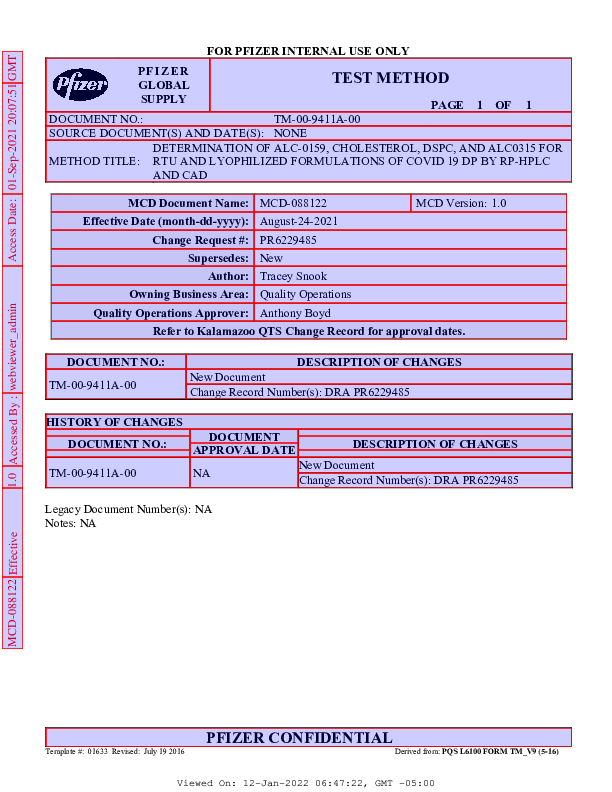

In [230]:
img = sample_page.to_image()
img.draw_rects(tf.cells)

In [231]:
cells_df.describe()

,x1,y1,x2,x3
count,64.000000,64.000000,64.000000,64.000000
mean,136.636491,303.847145,311.047900,329.770766
std,122.703264,130.805507,213.940601,129.732538
min,1.577500,51.024000,22.622475,82.705000
25%,45.667500,211.932000,153.750000,243.926250
50%,56.280000,284.985000,254.480000,303.225000
75%,249.000000,418.002500,566.512941,436.440000
max,561.120000,727.680000,572.152500,746.520000


## Intersections

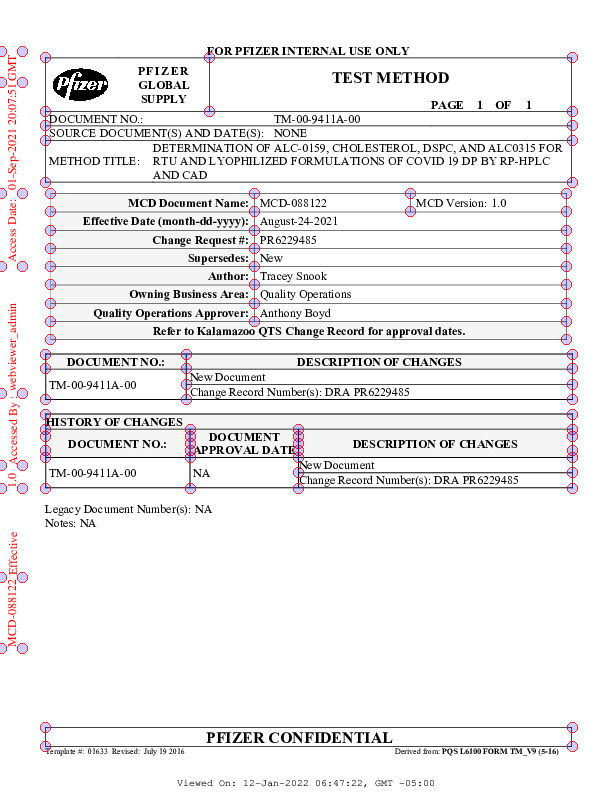

In [232]:
img = sample_page.to_image()
img.draw_circles(tf.intersections)

In [233]:
inters_df

,v,h
0,"[{'x0': 1.5775000000000006, 'y0': 143.34000000...","[{'x0': 1.6000000000000014, 'y0': 740.976, 'x1..."
1,"[{'x0': 1.5775000000000006, 'y0': 143.34000000...","[{'x0': 1.5100000000000016, 'y0': 709.29500000..."
2,"[{'x0': 1.5775000000000006, 'y0': 143.34000000...","[{'x0': 1.120000000000001, 'y0': 598.295000000..."
3,"[{'x0': 1.5775000000000006, 'y0': 143.34000000...","[{'x0': 1.120000000000001, 'y0': 525.836, 'x1'..."
4,"[{'x0': 1.5775000000000006, 'y0': 143.34000000...","[{'x0': 1.6099999999999994, 'y0': 398.71395, '..."
...,...,...
113,"[{'x0': 572.1525000000001, 'y0': 304.56, 'x1':...","[{'x0': 46.08, 'y0': 334.7039999999999, 'x1': ..."
114,"[{'x0': 572.1525000000001, 'y0': 304.56, 'x1':...","[{'x0': 298.8, 'y0': 319.32, 'x1': 572.28, 'y1..."
115,"[{'x0': 572.1525000000001, 'y0': 304.56, 'x1':...","[{'x0': 46.08, 'y0': 303.80875000000003, 'x1':..."
116,"[{'x0': 572.1525000000001, 'y0': 45.72, 'x1': ...","[{'x0': 45.84, 'y0': 64.32, 'x1': 571.08, 'y1'..."


In [238]:
tf.cells[0].

(1.5775000000000006, 51.024, 22.622475, 82.70499999999998)

In [249]:
def full_overlap(edge1, edge2):
    if (
        edge1[0] <= edge2[0] <= edge1[2] and
        edge1[0] <= edge2[2] <= edge1[2] and
        edge1[1] <= edge2[1] <= edge1[3] and
        edge1[1] <= edge2[3] <= edge1[3]
    ):
        return True
    
    return False

In [254]:
full_overlaps = {}
for cell_id_1, cell_1 in enumerate(tf.cells):
    for cell_id_2, cell_2 in enumerate(tf.cells):
        if cell_id_1 != cell_id_2 and full_overlap(cell_2, cell_1):
            full_overlaps[cell_id_1] = cell_id_2

In [256]:
full_overlaps

{}

### we have no overlapping cells!